## Packages needed
pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt


### 1.Downloading and Loading SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt 
import yfinance as yf
np.NaN = np.nan  # Force alias for compatibility
import pandas_ta
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#load sp500 list from wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
#some symbols have a dot in them so we will replace it with a dash
sp500['Symbol']= sp500['Symbol'].str.replace('.','-')



In [3]:
# need to note this list is not survivorship bias free
symbols_list = sp500['Symbol'].unique().tolist() 

end_date = '2025-06-13'

start_date=pd.to_datetime(end_date)-pd.DateOffset(365*8)

In [4]:
df = yf.download(
    tickers=symbols_list,
    start=start_date,
    end=end_date,
    group_by='column',
    auto_adjust=False  # keep raw data
)

# Check columns
print(df.head())


[*********************100%***********************]  502 of 502 completed


Price       Adj Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2017-06-15  55.615246  33.609402  50.142002  NaN  41.747673  29.893080   
2017-06-16  55.897034  33.138897  50.461632  NaN  41.825771  29.931116   
2017-06-19  56.873890  34.086914  50.667576  NaN  42.415714  30.016697   
2017-06-20  56.667255  33.777107  50.582336  NaN  42.311600  29.959642   
2017-06-21  56.160030  33.977440  50.667576  NaN  42.138084  29.896250   

Price                                                     ...   Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...      WTW   
Date                                                      ...            
2017-06-15  112.359810  137.520004  68.541588  33.476337  ...   451900   
2017-06-16  112.828598  137.839996  68.790855  33.634396  ...  1180000   
2017-06-19  113.014336  140.350006  6

In [5]:
stacked_df = df.stack()
stacked_df.index.names = ['date', 'ticker']
stacked_df.columns = stacked_df.columns.str.lower()
print(stacked_df)


Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-06-15 A        55.615246   59.209999   59.290001   58.820000   59.220001   
           AAPL     33.609402   36.072498   36.119999   35.552502   35.830002   
           ABBV     50.142002   70.599998   70.650002   69.879997   70.339996   
           ABT      41.747673   48.119999   48.340000   47.369999   47.580002   
           ACGL     29.893080   31.436666   31.570000   31.203333   31.333332   
...                       ...         ...         ...         ...         ...   
2025-06-12 XYL     127.300003  127.300003  127.550003  126.050003  126.430000   
           YUM     143.970001  143.970001  143.970001  142.460007  143.210007   
           ZBH      93.018784   93.260002   94.309998   92.970001   94.010002   
           ZBRA    292.679993  292.679993  293.390015  290.000000  290.029999   
           ZTS     168.82000

### 2.Calculate features and technical indicators for each stock
###### .Garman-Klass Volatility 
###### .RSI
###### .Bollinger Bands
###### .ATR
###### .MACD
###### .Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2 \ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [6]:
stacked_df['garman_klass_vol'] = (np.log(stacked_df['high'])-np.log(stacked_df['low']))**2/2-(2*np.log(2)-1)*(np.log(stacked_df['adj close'])-np.log(stacked_df['open']))**2
stacked_df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-06-15 A        55.615246   59.209999   59.290001   58.820000   59.220001   
           AAPL     33.609402   36.072498   36.119999   35.552502   35.830002   
           ABBV     50.142002   70.599998   70.650002   69.879997   70.339996   
           ABT      41.747673   48.119999   48.340000   47.369999   47.580002   
           ACGL     29.893080   31.436666   31.570000   31.203333   31.333332   
...                       ...         ...         ...         ...         ...   
2025-06-12 XYL     127.300003  127.300003  127.550003  126.050003  126.430000   
           YUM     143.970001  143.970001  143.970001  142.460007  143.210007   
           ZBH      93.018784   93.260002   94.309998   92.970001   94.010002   
           ZBRA    292.679993  292.679993  293.390015  290.000000  290.029999   
           ZTS     168.820007  168.820007  168.830002  165.520004  166.490005   

Price                   volume  garman_klass_vol  
date       ticker                                 
2017-06-15 A         1091800.0         -0.001492  
           AAPL    128661600.0         -0.001456  
           ABBV      4682700.0         -0.044198  
           ABT       9366700.0         -0.006400  
           ACGL      1405800.0         -0.000787  
...                        ...               ...  
2025-06-12 XYL        791000.0          0.000052  
           YUM       1096400.0          0.000045  
           ZBH       1110800.0          0.000059  
           ZBRA       295900.0          0.000036  
           ZTS       2334600.0          0.000121  

[988853 rows x 7 columns]

#### Relative Strength Index (RSI)
It is a momentum oscillator that measures the speed and magnitude of price movements. It ranges from 0 to 100 and is typically used to identify:

Overbought conditions (RSI > 70 → potential price drop)

Oversold conditions (RSI < 30 → potential price rise)

In [7]:
#groupby(level=1): Groups by ticker (level 1 of the MultiIndex) to calculate RSI per stock.
#transform: Ensures the output aligns with the original DataFrame’s shape.
#length=20: Uses a 20-day lookback (default is 14).
stacked_df['rsi'] = stacked_df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20)) 
stacked_df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-06-15 A        55.615246   59.209999   59.290001   58.820000   59.220001   
           AAPL     33.609402   36.072498   36.119999   35.552502   35.830002   
           ABBV     50.142002   70.599998   70.650002   69.879997   70.339996   
           ABT      41.747673   48.119999   48.340000   47.369999   47.580002   
           ACGL     29.893080   31.436666   31.570000   31.203333   31.333332   
...                       ...         ...         ...         ...         ...   
2025-06-12 XYL     127.300003  127.300003  127.550003  126.050003  126.430000   
           YUM     143.970001  143.970001  143.970001  142.460007  143.210007   
           ZBH      93.018784   93.260002   94.309998   92.970001   94.010002   
           ZBRA    292.679993  292.679993  293.390015  290.000000  290.029999   
           ZTS     168.820007  168.820007  168.830002  165.520004  166.490005   

Price                   volume  garman_klass_vol        rsi  
date       ticker                                            
2017-06-15 A         1091800.0         -0.001492        NaN  
           AAPL    128661600.0         -0.001456        NaN  
           ABBV      4682700.0         -0.044198        NaN  
           ABT       9366700.0         -0.006400        NaN  
           ACGL      1405800.0         -0.000787        NaN  
...                        ...               ...        ...  
2025-06-12 XYL        791000.0          0.000052  58.211781  
           YUM       1096400.0          0.000045  46.499559  
           ZBH       1110800.0          0.000059  44.302178  
           ZBRA       295900.0          0.000036  55.106227  
           ZTS       2334600.0          0.000121  56.975460  

[988853 rows x 8 columns]

#### For each indicator from now on we would like to normalize and scale the indicator
Standardize values (e.g., RSI is 0–100, but Bollinger Bands are unbounded).

Avoid dominance by large numbers (e.g., dollar volume vs. RSI).

Improve machine learning compatibility for later use.

#### Bollinger Bands
Bollinger Bands are a technical indicator that shows:

Middle Band (BBM): 20-day moving average (simple average of the last 20 prices).

Upper Band (BBU): Middle Band + (2 × Standard Deviation of prices over 20 days).

Lower Band (BBL): Middle Band - (2 × Standard Deviation of prices over 20 days).

##### Why ±2σ? The Statistical Intuition
Standard Deviation (σ) measures how "spread out" prices are around the average.

High σ = Volatile market (prices swing wildly).

Low σ = Stable market (prices stay close to average).

In normal distributions (bell curves), ~95% of data falls within ±2σ of the mean.

This means prices should theoretically stay inside the bands 95% of the time.

When prices break outside the bands, it’s statistically rare (a potential reversal signal).

#### Practical Trading Intuition
Upper Band (SMA + 2σ):

When price touches here, it’s "overbought" (statistically stretched too high).

Traders expect a pullback toward the mean.

Lower Band (SMA - 2σ):

When price touches here, it’s "oversold" (statistically stretched too low).

Traders expect a bounce toward the mean.

In [8]:
pandas_ta.bbands(close=stacked_df.xs('AAPL', level=1)['adj close'],length=20)


,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
date,,,,,
2017-06-15,NaN,NaN,NaN,NaN,NaN
2017-06-16,NaN,NaN,NaN,NaN,NaN
2017-06-19,NaN,NaN,NaN,NaN,NaN
2017-06-20,NaN,NaN,NaN,NaN,NaN
2017-06-21,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-06-06,194.012106,204.2580,214.503895,10.032307,0.483505
2025-06-09,194.452915,204.4170,214.381085,9.748783,0.351115
2025-06-10,194.465790,204.0110,213.556210,9.357545,0.429755


In [9]:
stacked_df['bblow'] = stacked_df.groupby(level=1)['adj close'].transform(
    lambda x: (
        pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0] 
        if pandas_ta.bbands(close=np.log1p(x), length=20) is not None 
        else np.nan
    )
)
stacked_df['bbmid'] = stacked_df.groupby(level=1)['adj close'].transform(
    lambda x: (
        pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1] 
        if pandas_ta.bbands(close=np.log1p(x), length=20) is not None 
        else np.nan
    )
)
stacked_df['bbhigh'] = stacked_df.groupby(level=1)['adj close'].transform(
    lambda x: (
        pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2] 
        if pandas_ta.bbands(close=np.log1p(x), length=20) is not None 
        else np.nan
    )
)
stacked_df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-06-15 A        55.615246   59.209999   59.290001   58.820000   59.220001   
           AAPL     33.609402   36.072498   36.119999   35.552502   35.830002   
           ABBV     50.142002   70.599998   70.650002   69.879997   70.339996   
           ABT      41.747673   48.119999   48.340000   47.369999   47.580002   
           ACGL     29.893080   31.436666   31.570000   31.203333   31.333332   
...                       ...         ...         ...         ...         ...   
2025-06-12 XYL     127.300003  127.300003  127.550003  126.050003  126.430000   
           YUM     143.970001  143.970001  143.970001  142.460007  143.210007   
           ZBH      93.018784   93.260002   94.309998   92.970001   94.010002   
           ZBRA    292.679993  292.679993  293.390015  290.000000  290.029999   
           ZTS     168.820007  168.820007  168.830002  165.520004  166.490005   

Price                   volume  garman_klass_vol        rsi     bblow  \
date       ticker                                                       
2017-06-15 A         1091800.0         -0.001492        NaN       NaN   
           AAPL    128661600.0         -0.001456        NaN       NaN   
           ABBV      4682700.0         -0.044198        NaN       NaN   
           ABT       9366700.0         -0.006400        NaN       NaN   
           ACGL      1405800.0         -0.000787        NaN       NaN   
...                        ...               ...        ...       ...   
2025-06-12 XYL        791000.0          0.000052  58.211781  4.829744   
           YUM       1096400.0          0.000045  46.499559  4.959697   
           ZBH       1110800.0          0.000059  44.302178  4.508708   
           ZBRA       295900.0          0.000036  55.106227  5.653001   
           ZTS       2334600.0          0.000121  56.975460  5.081321   

Price                 bbmid    bbhigh  
date       ticker                      
2017-06-15 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2025-06-12 XYL     4.847282  4.864821  
           YUM     4.982215  5.004734  
           ZBH     4.544726  4.580744  
           ZBRA    5.683734  5.714467  
           ZTS     5.117335  5.153349  

[988853 rows x 11 columns]

#### ATR (Average True Range)
The Average True Range (ATR) measures market volatility by showing how much an asset's price moves on average over a given period (usually 14 days). Unlike Bollinger Bands, it doesn’t predict direction—just how wild or calm the price swings are.

##### 1. True Range (TR)
For each day, calculate the largest of these:

Today’s High – Today’s Low
(Normal daily range)

|Today’s High – Yesterday’s Close|
(Gap up or down from yesterday’s close)

|Today’s Low – Yesterday’s Close|
(Gap up or down from yesterday’s close)

##### 2. Average True Range (ATR)
Smooth the TR values over a period (default=14 days) using a moving average:

ATR=MA of TR over 14 days

##### Intuition & Why It Matters
High ATR = High Volatility (Big price swings, risky trades).

Low ATR = Low Volatility (Calm market, smaller moves).





In [10]:
def compute_atr(stock_data):
    atr=pandas_ta.atr(high=stock_data['high'],
                      low=stock_data['low'],
                      close=stock_data['close'],
                      length=14)
    return atr.sub(atr.mean()).div(atr.std())

stacked_df['atr']=stacked_df.groupby(level=1, group_keys=False).apply(compute_atr)


#### MACD (Moving Average Convergence Divergence)
The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. It helps identify:

Trend direction (up or down).

Momentum strength (how strong the trend is).

Potential reversals (when the trend might change).
##### 1.MACD Line:
MACD Line=12-dayEMA −   26-dayEMA         (Short-term EMA minus long-term EMA).
##### 2.Signal Line:
Signal Line= 9-dayEMA of MACD Line        (Smoothed version of the MACD Line).
##### 3.MACD Histogram:
Histogram=MACD Line − Signal Line          

###### Where: EMA = Exponential Moving Average (gives more weight to recent prices).






In [11]:
def compute_macd(close):
    # Ensure we have enough data points (minimum 26 periods)
    if len(close) < 26:
        return pd.Series(np.nan, index=close.index)
    
    # Calculate MACD - explicitly use default parameters
    macd_df = pandas_ta.macd(
        close=close,
        fast=12,    # standard fast period
        slow=26,    # standard slow period
        signal=9,   # standard signal period
        append=False
    )
    
    # Check if calculation succeeded
    if macd_df is None:
        return pd.Series(np.nan, index=close.index)
    
    # Get MACD line (first column) and normalize
    macd_line = macd_df.iloc[:, 0]
    return macd_line.sub(macd_line.mean()).div(macd_line.std())

# Apply to each stock's adjusted close
stacked_df['macd'] = stacked_df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

#### Dollar Volume Indicator:
Dollar volume measures how much money is actually traded in a stock:
Dollar Volume= Price × Number of Shares Traded (Volume)

Why It Matters?
##### Liquidity Check:

High dollar volume = Easy to buy/sell without moving prices.
Low dollar volume = Illiquid (risk of slippage).

##### Institutional Interest:

Big money moves markets. High dollar volume often means institutions are trading.

##### Trend Confirmation:

Rising price + Rising dollar volume = Strong trend.

Rising price + Falling dollar volume = Weak trend (may reverse).


In [12]:
#we devide by 1 million because millions of shares are created each day
stacked_df['dollar_volume']=stacked_df['adj close']*stacked_df['volume']/1e6  

In [13]:
stacked_df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-06-15 A        55.615246   59.209999   59.290001   58.820000   59.220001   
           AAPL     33.609402   36.072498   36.119999   35.552502   35.830002   
           ABBV     50.142002   70.599998   70.650002   69.879997   70.339996   
           ABT      41.747673   48.119999   48.340000   47.369999   47.580002   
           ACGL     29.893080   31.436666   31.570000   31.203333   31.333332   
...                       ...         ...         ...         ...         ...   
2025-06-12 XYL     127.300003  127.300003  127.550003  126.050003  126.430000   
           YUM     143.970001  143.970001  143.970001  142.460007  143.210007   
           ZBH      93.018784   93.260002   94.309998   92.970001   94.010002   
           ZBRA    292.679993  292.679993  293.390015  290.000000  290.029999   
           ZTS     168.820007  168.820007  168.830002  165.520004  166.490005   

Price                   volume  garman_klass_vol        rsi     bblow  \
date       ticker                                                       
2017-06-15 A         1091800.0         -0.001492        NaN       NaN   
           AAPL    128661600.0         -0.001456        NaN       NaN   
           ABBV      4682700.0         -0.044198        NaN       NaN   
           ABT       9366700.0         -0.006400        NaN       NaN   
           ACGL      1405800.0         -0.000787        NaN       NaN   
...                        ...               ...        ...       ...   
2025-06-12 XYL        791000.0          0.000052  58.211781  4.829744   
           YUM       1096400.0          0.000045  46.499559  4.959697   
           ZBH       1110800.0          0.000059  44.302178  4.508708   
           ZBRA       295900.0          0.000036  55.106227  5.653001   
           ZTS       2334600.0          0.000121  56.975460  5.081321   

Price                 bbmid    bbhigh       atr      macd  dollar_volume  
date       ticker                                                         
2017-06-15 A            NaN       NaN       NaN       NaN      60.720725  
           AAPL         NaN       NaN       NaN       NaN    4324.239398  
           ABBV         NaN       NaN       NaN       NaN     234.799953  
           ABT          NaN       NaN       NaN       NaN     391.037929  
           ACGL         NaN       NaN       NaN       NaN      42.023692  
...                     ...       ...       ...       ...            ...  
2025-06-12 XYL     4.847282  4.864821 -0.141370  0.793319     100.694302  
           YUM     4.982215  5.004734  0.514531 -0.732802     157.848709  
           ZBH     4.544726  4.580744 -0.657914 -0.502744     103.325265  
           ZBRA    5.683734  5.714467 -0.222647  0.643769      86.604010  
           ZTS     5.117335  5.153349  0.394222  0.852955     394.127189  

[988853 rows x 14 columns]

### 3.Aggregate to monthly level and filter top 150 most liquid stocks for each month
.To reduce training time and exeriment with features and strategies, we convert the business-daily data to month-end frequency

In [14]:
#stacked_df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')
last_cols=[c for c in stacked_df.columns.unique(0) if c not in['dollar_volume','volume','open','high','low','close'] ]
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bblow',
 'bbmid',
 'bbhigh',
 'atr',
 'macd']

In [15]:
data = pd.concat([stacked_df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),stacked_df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()

In [16]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-07-31 A           91.825062   56.285103         -0.001750  47.968126   
           AAPL      2915.393053   34.643604         -0.002275  53.922173   
           ABBV       258.186414   50.098259         -0.045102  40.338915   
           ABT        247.002308   42.903435         -0.008054  52.039069   
           ACGL        42.369787   30.828129         -0.000395  56.175614   
...                          ...         ...               ...        ...   
2025-06-30 XYL        137.887689  127.300003          0.000052  58.211781   
           YUM        240.212683  143.970001          0.000045  46.499559   
           ZBH        127.751454   93.018784          0.000059  44.302178   
           ZBRA       119.948960  292.679993          0.000036  55.106227   
           ZTS        451.771666  168.820007          0.000121  56.975460   

                      bblow     bbmid    bbhigh       atr      macd  
date       ticker                                                    
2017-07-31 A       4.032208  4.058643  4.085079 -1.682870  0.031722  
           AAPL    3.528763  3.570535  3.612307 -1.349384 -0.054142  
           ABBV    3.933486  3.964924  3.996362 -1.425838 -0.181477  
           ABT     3.739666  3.782008  3.824349 -1.687065  0.126145  
           ACGL    3.423910  3.453108  3.482306 -1.129402  0.115339  
...                     ...       ...       ...       ...       ...  
2025-06-30 XYL     4.829744  4.847282  4.864821 -0.141370  0.793319  
           YUM     4.959697  4.982215  5.004734  0.514531 -0.732802  
           ZBH     4.508708  4.544726  4.580744 -0.657914 -0.502744  
           ZBRA    5.653001  5.683734  5.714467 -0.222647  0.643769  
           ZTS     5.081321  5.117335  5.153349  0.394222  0.852955  

[47225 rows x 9 columns]

#### .Calculate 5-year rolling average of dollar volume for each stock before filtering
##### Consistent Liquidity Measurement

A single month's dollar volume could be misleading (earnings reports, etc.)

5-year average shows which stocks are reliably liquid

##### Institutional-Grade Filtering

Big funds want stocks that are consistently tradable

Avoids "flash in the pan" stocks that might have one good month

##### Equal Treatment of All Stocks

Each stock gets evaluated on the same 5-year standard

Not biased by recent performance alone

In [17]:
data['dollar_volume']= (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data= data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi     bblow  \
date       ticker                                                      
2018-06-30 AAPL     43.787853         -0.001201  49.582414  3.782213   
           ABBV     68.034233         -0.037124  38.080367  4.215851   
           ABT      53.980732         -0.006434  47.018511  3.997916   
           ACN     147.388290         -0.004383  58.053371  4.953232   
           ADBE    243.809998          0.000110  50.937236  5.474781   
...                       ...               ...        ...       ...   
2025-06-30 WDAY    250.690002          0.000085  50.067986  5.448886   
           WFC      74.010002          0.000160  51.880340  4.301292   
           WMT      94.830002          0.000188  45.980558  4.563390   
           XOM     109.730003          0.000142  58.879805  4.613734   
           ZTS     168.820007          0.000121  56.975460  5.081321   

                      bbmid    bbhigh       atr      macd  
date       ticker                                          
2018-06-30 AAPL    3.819717  3.857222 -1.257540 -0.278059  
           ABBV    4.278428  4.341006 -0.630223 -1.004857  
           ABT     4.027670  4.057425 -1.320548 -0.353399  
           ACN     4.985015  5.016799 -0.948335  0.027958  
           ADBE    5.521728  5.568676 -1.127849 -0.115114  
...                     ...       ...       ...       ...  
2025-06-30 WDAY    5.544237  5.639588 -0.118189 -0.108067  
           WFC     4.329057  4.356822  1.084185  0.725919  
           WMT     4.589857  4.616325  2.336360  0.000204  
           XOM     4.660776  4.707818  0.488245  0.178141  
           ZTS     5.117335  5.153349  0.394222  0.852955  

[12665 rows x 8 columns]

### 4.Calculate Monthly Returns for different time horizons as features
.To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method.pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [18]:
#g= stacked_df.xs('AAPL', level=1)

#we want to clip the outliers ie: for all values which are above our outlier_threshhold we will asign the threshhold of that percentile(0.005 which means the 99.95 percentile)
def calculate_lag(g):

    outlier_cutoff= 0.005
    lags= [1, 2 , 3, 6, 9, 12]
    for lag in lags:
        g[f'return_{lag}m'] = (g['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return(g)
data=data.groupby(level=1, group_keys=False).apply(calculate_lag).dropna()
data

adj close  garman_klass_vol        rsi     bblow  \
date       ticker                                                      
2019-06-30 AAPL     47.530727         -0.000672  56.282146  3.781842   
           ABBV     55.922276         -0.020365  42.046322  3.983328   
           ABT      75.733635         -0.003883  64.665784  4.254858   
           ACN     169.383621         -0.002625  58.459472  5.099023   
           ADBE    294.649994          0.000057  58.679794  5.566200   
...                       ...               ...        ...       ...   
2025-06-30 VZ       43.160000          0.000149  48.302411  3.782111   
           WDAY    250.690002          0.000085  50.067986  5.448886   
           WFC      74.010002          0.000160  51.880340  4.301292   
           WMT      94.830002          0.000188  45.980558  4.563390   
           XOM     109.730003          0.000142  58.879805  4.613734   

                      bbmid    bbhigh       atr      macd  return_1m  \
date       ticker                                                      
2019-06-30 AAPL    3.856704  3.931566 -1.118917  0.025310   0.130519   
           ABBV    4.084980  4.186631 -0.243732 -0.932056  -0.052014   
           ABT     4.315521  4.376183 -0.965841  0.936570   0.104689   
           ACN     5.129683  5.160344 -1.080018  0.158223   0.037626   
           ADBE    5.645850  5.725500 -0.894170  0.424366   0.087671   
...                     ...       ...       ...       ...        ...   
2025-06-30 VZ      3.798897  3.815684 -0.495913  0.023282  -0.018198   
           WDAY    5.544237  5.639588 -0.118189 -0.108067   0.012030   
           WFC     4.329057  4.356822  1.084185  0.725919  -0.010297   
           WMT     4.589857  4.616325  2.336360  0.000204  -0.039404   
           XOM     4.660776  4.707818  0.488245  0.178141   0.072630   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-06-30 AAPL    -0.004965   0.015095   0.039950  -0.013235    0.006858  
           ABBV    -0.042929  -0.029421  -0.032724  -0.024888   -0.016205  
           ABT      0.028136   0.018439   0.026936   0.016743    0.028618  
           ACN      0.005732   0.019101   0.047516   0.011115    0.011659  
           ADBE     0.009291   0.034051   0.045016   0.009775    0.015908  
...                      ...        ...        ...        ...         ...  
2025-06-30 VZ      -0.010266  -0.011198   0.018466   0.001027    0.009270  
           WDAY     0.011546   0.023917  -0.004798   0.002823    0.009590  
           WFC      0.023702   0.012047   0.010501   0.032320    0.020527  
           WMT     -0.011327   0.026872   0.008965   0.018853    0.029345  
           XOM      0.023905  -0.023501   0.006346  -0.004409   -0.001139  

[10464 rows x 14 columns]

### 5.Fama-French Factors
Developed by Nobel winners Eugene Fama and Kenneth French, these are 5 key forces that explain stock returns better than just market risk (Beta). Used to:

Analyze portfolio performance ("Why did my stocks underperform?")

Build better portfolios (target exposure to these factors)
##### 1. Market Risk (Rm - Rf):
Market Return−Risk-Free Rate
What it captures:
Stocks move with the overall market.
High Beta = More sensitive to market swings.

##### 2. Size (SMB - Small Minus Big):
Avg Return of Small Stocks−Avg Return of Big Stocks
What it captures:
Small-cap stocks tend to outperform large-caps long-term.

##### 3. Value (HML - High Minus Low)
Avg Return of Value Stocks−Avg Return of Growth Stocks

Value stocks: Low P/B, High Dividends.

Growth stocks: High P/B, Tech-like.

What it captures:
Cheap "value" stocks often beat expensive "growth" stocks.

##### 4. Profitability (RMW - Robust Minus Weak):
Avg Return of High-Profit Firms−Avg Return of Low-Profit Firms
What it captures:
Profitable companies outperform unprofitable ones.

##### 5. Investment (CMA - Conservative Minus Aggressive):
Avg Return of Low-Investment Firms−Avg Return of High-Investment Firms
What it captures:
Companies that invest wisely (not excessively) perform better.








In [19]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name='date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024
...,...,...,...,...,...
2024-12-31,-0.0315,-0.0384,-0.0300,0.0191,-0.0121
2025-01-31,0.0280,-0.0122,0.0162,-0.0233,-0.0324
2025-02-28,-0.0243,-0.0493,0.0491,0.0109,0.0306


In [20]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-06-30 AAPL    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.130519
           ABBV    0.0692  0.0037 -0.0067  0.0091 -0.0040  -0.052014
           ABT     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.104689
           ACN     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.037626
           ADBE    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.087671
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10185 rows x 6 columns]

In [21]:
#filter out stocks with less that 10 months of data.
observations = factor_data.groupby(level=1).size()
valid_stocks= observations[observations>=10]
valid_stocks
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-06-30 AAPL    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.130519
           ABBV    0.0692  0.0037 -0.0067  0.0091 -0.0040  -0.052014
           ABT     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.104689
           ACN     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.037626
           ADBE    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.087671
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10105 rows x 6 columns]

#### Calculate the Rolling Factor Betas
What Are We Calculating?
We're measuring how sensitive each stock is to the 5 Fama-French factors (Market, Size, Value, etc.) over time.

Beta = Sensitivity (e.g., a beta of 1.5 for "Mkt-RF" means the stock moves 1.5x as much as the market).

Rolling: We update this sensitivity every month using the past 24 months of data.

In [22]:
betas= (factor_data.groupby(level=1,
                           group_keys=False)
                           .apply(lambda x:RollingOLS(endog=x['return_1m'],
                                                     exog=sm.add_constant(x.drop('return_1m',axis=1)),
                                                     window=min(24,x.shape[0]),
                                                     min_nobs=len(x.columns)+1)
                            .fit(params_only=True)
                            .params
                            .drop('const',axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.904653 -1.064243  0.905420  0.658047 -0.070740
           WDAY    1.108715 -0.937077  0.037348 -1.896113 -0.421493
           WFC     0.877758 -0.095225  0.559150 -1.655162 -0.085205
           WMT     0.787343  0.091221 -0.722477  0.394635  0.633480
           XOM     0.476823 -0.287362  1.039673  1.215638  0.114549

[10105 rows x 5 columns]

In [23]:
#We want to join the rolling factor betas to our current features
#Now we have the rolling factor betas where we used the factor at the begining of the month and the return at the end of the month
#At the end of the month we would be able to run the regressions and have the betas but we will have them in the next month
#we cannot just blindly join them to the features data we have so far we have to shift them first one month forward
#shift one month forward on the ticker level
#for example the rolling factor betas for the end of octobre we would know them for novembre
data = data.join(betas.groupby('ticker').shift())

data

adj close  garman_klass_vol        rsi     bblow  \
date       ticker                                                      
2019-06-30 AAPL     47.530727         -0.000672  56.282146  3.781842   
           ABBV     55.922276         -0.020365  42.046322  3.983328   
           ABT      75.733635         -0.003883  64.665784  4.254858   
           ACN     169.383621         -0.002625  58.459472  5.099023   
           ADBE    294.649994          0.000057  58.679794  5.566200   
...                       ...               ...        ...       ...   
2025-06-30 VZ       43.160000          0.000149  48.302411  3.782111   
           WDAY    250.690002          0.000085  50.067986  5.448886   
           WFC      74.010002          0.000160  51.880340  4.301292   
           WMT      94.830002          0.000188  45.980558  4.563390   
           XOM     109.730003          0.000142  58.879805  4.613734   

                      bbmid    bbhigh       atr      macd  return_1m  \
date       ticker                                                      
2019-06-30 AAPL    3.856704  3.931566 -1.118917  0.025310   0.130519   
           ABBV    4.084980  4.186631 -0.243732 -0.932056  -0.052014   
           ABT     4.315521  4.376183 -0.965841  0.936570   0.104689   
           ACN     5.129683  5.160344 -1.080018  0.158223   0.037626   
           ADBE    5.645850  5.725500 -0.894170  0.424366   0.087671   
...                     ...       ...       ...       ...        ...   
2025-06-30 VZ      3.798897  3.815684 -0.495913  0.023282  -0.018198   
           WDAY    5.544237  5.639588 -0.118189 -0.108067   0.012030   
           WFC     4.329057  4.356822  1.084185  0.725919  -0.010297   
           WMT     4.589857  4.616325  2.336360  0.000204  -0.039404   
           XOM     4.660776  4.707818  0.488245  0.178141   0.072630   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2019-06-30 AAPL    -0.004965   0.015095   0.039950  -0.013235    0.006858   
           ABBV    -0.042929  -0.029421  -0.032724  -0.024888   -0.016205   
           ABT      0.028136   0.018439   0.026936   0.016743    0.028618   
           ACN      0.005732   0.019101   0.047516   0.011115    0.011659   
           ADBE     0.009291   0.034051   0.045016   0.009775    0.015908   
...                      ...        ...        ...        ...         ...   
2025-06-30 VZ      -0.010266  -0.011198   0.018466   0.001027    0.009270   
           WDAY     0.011546   0.023917  -0.004798   0.002823    0.009590   
           WFC      0.023702   0.012047   0.010501   0.032320    0.020527   
           WMT     -0.011327   0.026872   0.008965   0.018853    0.029345   
           XOM      0.023905  -0.023501   0.006346  -0.004409   -0.001139   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2019-06-30 AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
           ADBE       NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2025-06-30 VZ         NaN  NaN  NaN  NaN  NaN  
           WDAY       NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  

[10464 rows x 19 columns]

In [24]:
#We want to impute the missing values of each factor with the average for that factor beta
factors=['Mkt-RF', 'SMB',	'HML',	'RMW',	'CMA']
data.loc[:,factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data= data.drop('adj close',axis=1)
data = data.dropna()
data

garman_klass_vol        rsi     bblow     bbmid    bbhigh  \
date       ticker                                                              
2019-06-30 AAPL           -0.000672  56.282146  3.781842  3.856704  3.931566   
           ABBV           -0.020365  42.046322  3.983328  4.084980  4.186631   
           ABT            -0.003883  64.665784  4.254858  4.315521  4.376183   
           ACN            -0.002625  58.459472  5.099023  5.129683  5.160344   
           ADBE            0.000057  58.679794  5.566200  5.645850  5.725500   
...                             ...        ...       ...       ...       ...   
2025-06-30 VZ              0.000149  48.302411  3.782111  3.798897  3.815684   
           WDAY            0.000085  50.067986  5.448886  5.544237  5.639588   
           WFC             0.000160  51.880340  4.301292  4.329057  4.356822   
           WMT             0.000188  45.980558  4.563390  4.589857  4.616325   
           XOM             0.000142  58.879805  4.613734  4.660776  4.707818   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -1.118917  0.025310   0.130519  -0.004965   0.015095   
           ABBV   -0.243732 -0.932056  -0.052014  -0.042929  -0.029421   
           ABT    -0.965841  0.936570   0.104689   0.028136   0.018439   
           ACN    -1.080018  0.158223   0.037626   0.005732   0.019101   
           ADBE   -0.894170  0.424366   0.087671   0.009291   0.034051   
...                     ...       ...        ...        ...        ...   
2025-06-30 VZ     -0.495913  0.023282  -0.018198  -0.010266  -0.011198   
           WDAY   -0.118189 -0.108067   0.012030   0.011546   0.023917   
           WFC     1.084185  0.725919  -0.010297   0.023702   0.012047   
           WMT     2.336360  0.000204  -0.039404  -0.011327   0.026872   
           XOM     0.488245  0.178141   0.072630   0.023905  -0.023501   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.039950  -0.013235    0.006858  1.229631 -0.077247   
           ABBV    -0.032724  -0.024888   -0.016205  0.544226  0.121580   
           ABT      0.026936   0.016743    0.028618  0.786684 -0.064381   
           ACN      0.047516   0.011115    0.011659  1.155022 -0.185468   
           ADBE     0.045016   0.009775    0.015908  1.390365 -0.647690   
...                      ...        ...         ...       ...       ...   
2025-06-30 VZ       0.018466   0.001027    0.009270  0.529394 -0.550145   
           WDAY    -0.004798   0.002823    0.009590  1.159843 -0.659799   
           WFC      0.010501   0.032320    0.020527  1.070988 -0.131682   
           WMT      0.008965   0.018853    0.029345  0.673068 -0.287095   
           XOM      0.006346  -0.004409   -0.001139  0.936243 -0.073503   

                        HML       RMW       CMA  
date       ticker                                
2019-06-30 AAPL   -0.690813  0.384567  0.404053  
           ABBV   -0.054222  0.267487  0.596070  
           ABT    -0.346193  0.063786  1.002192  
           ACN    -0.239550  0.196360 -0.049158  
           ADBE   -0.215557  0.265958 -0.443218  
...                     ...       ...       ...  
2025-06-30 VZ      0.411652  0.161433 -0.001565  
           WDAY   -0.294352 -1.000775 -0.482115  
           WFC     1.585706 -0.785856 -1.088219  
           WMT    -0.326620  0.256938  0.519937  
           XOM     0.932540 -0.339608  0.357481  

[10234 rows x 18 columns]

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10234 entries, (Timestamp('2019-06-30 00:00:00'), 'AAPL') to (Timestamp('2025-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10234 non-null  float64
 1   rsi               10234 non-null  float64
 2   bblow             10234 non-null  float64
 3   bbmid             10234 non-null  float64
 4   bbhigh            10234 non-null  float64
 5   atr               10234 non-null  float64
 6   macd              10234 non-null  float64
 7   return_1m         10234 non-null  float64
 8   return_2m         10234 non-null  float64
 9   return_3m         10234 non-null  float64
 10  return_6m         10234 non-null  float64
 11  return_9m         10234 non-null  float64
 12  return_12m        10234 non-null  float64
 13  Mkt-RF            10234 non-null  float64
 14  SMB               10234 non-null  float64
 15  HML       

### 6.For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

#### K-Means Clustering
.You may want to initialize predefined centroids for each cluster based on your research


In [26]:
from sklearn.cluster import KMeans

def get_clusters(data):
    data['cluster']= KMeans(n_clusters=4,
                            random_state=0,
                            init='random').fit(data).labels_
    return(data)

data = data.dropna().groupby('date',group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi     bblow     bbmid    bbhigh  \
date       ticker                                                              
2019-06-30 AAPL           -0.000672  56.282146  3.781842  3.856704  3.931566   
           ABBV           -0.020365  42.046322  3.983328  4.084980  4.186631   
           ABT            -0.003883  64.665784  4.254858  4.315521  4.376183   
           ACN            -0.002625  58.459472  5.099023  5.129683  5.160344   
           ADBE            0.000057  58.679794  5.566200  5.645850  5.725500   
...                             ...        ...       ...       ...       ...   
2025-06-30 VZ              0.000149  48.302411  3.782111  3.798897  3.815684   
           WDAY            0.000085  50.067986  5.448886  5.544237  5.639588   
           WFC             0.000160  51.880340  4.301292  4.329057  4.356822   
           WMT             0.000188  45.980558  4.563390  4.589857  4.616325   
           XOM             0.000142  58.879805  4.613734  4.660776  4.707818   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -1.118917  0.025310   0.130519  -0.004965   0.015095   
           ABBV   -0.243732 -0.932056  -0.052014  -0.042929  -0.029421   
           ABT    -0.965841  0.936570   0.104689   0.028136   0.018439   
           ACN    -1.080018  0.158223   0.037626   0.005732   0.019101   
           ADBE   -0.894170  0.424366   0.087671   0.009291   0.034051   
...                     ...       ...        ...        ...        ...   
2025-06-30 VZ     -0.495913  0.023282  -0.018198  -0.010266  -0.011198   
           WDAY   -0.118189 -0.108067   0.012030   0.011546   0.023917   
           WFC     1.084185  0.725919  -0.010297   0.023702   0.012047   
           WMT     2.336360  0.000204  -0.039404  -0.011327   0.026872   
           XOM     0.488245  0.178141   0.072630   0.023905  -0.023501   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.039950  -0.013235    0.006858  1.229631 -0.077247   
           ABBV    -0.032724  -0.024888   -0.016205  0.544226  0.121580   
           ABT      0.026936   0.016743    0.028618  0.786684 -0.064381   
           ACN      0.047516   0.011115    0.011659  1.155022 -0.185468   
           ADBE     0.045016   0.009775    0.015908  1.390365 -0.647690   
...                      ...        ...         ...       ...       ...   
2025-06-30 VZ       0.018466   0.001027    0.009270  0.529394 -0.550145   
           WDAY    -0.004798   0.002823    0.009590  1.159843 -0.659799   
           WFC      0.010501   0.032320    0.020527  1.070988 -0.131682   
           WMT      0.008965   0.018853    0.029345  0.673068 -0.287095   
           XOM      0.006346  -0.004409   -0.001139  0.936243 -0.073503   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-06-30 AAPL   -0.690813  0.384567  0.404053        0  
           ABBV   -0.054222  0.267487  0.596070        3  
           ABT    -0.346193  0.063786  1.002192        2  
           ACN    -0.239550  0.196360 -0.049158        0  
           ADBE   -0.215557  0.265958 -0.443218        0  
...                     ...       ...       ...      ...  
2025-06-30 VZ      0.411652  0.161433 -0.001565        1  
           WDAY   -0.294352 -1.000775 -0.482115        1  
           WFC     1.585706 -0.785856 -1.088219        1  
           WMT    -0.326620  0.256938  0.519937        0  
           XOM     0.932540 -0.339608  0.357481        3  

[10234 rows x 19 columns]

In [27]:
def plot_clusters(data):
    cluster_0=data[data['cluster']==0]
    cluster_1=data[data['cluster']==1]
    cluster_2=data[data['cluster']==2]
    cluster_3=data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5],cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5],cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5],cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5],cluster_3.iloc[:,1], color='black', label='cluster 3')
    plt.legend()
    plt.show()
    return


In [28]:
'''plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g=data.xs(i,level=0)
    plt.title(f'Date{i}')
    plot_clusters(g)'''

"plt.style.use('ggplot')\nfor i in data.index.get_level_values('date').unique().tolist():\n    g=data.xs(i,level=0)\n    plt.title(f'Date{i}')\n    plot_clusters(g)"

#### Apply pre-defined centroids:

 

In [29]:
target_rsi_values = [30 , 45 ,55 ,70]
initial_centroids= np.zeros((len(target_rsi_values), 18))
initial_centroids[:,5] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [30]:
data= data.drop('cluster',axis=1)
def get_clusters(data):
    data['cluster']= KMeans(n_clusters=4,
                            random_state=0,
                            init=initial_centroids).fit(data).labels_
    return(data)

data = data.dropna().groupby('date',group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi     bblow     bbmid    bbhigh  \
date       ticker                                                              
2019-06-30 AAPL           -0.000672  56.282146  3.781842  3.856704  3.931566   
           ABBV           -0.020365  42.046322  3.983328  4.084980  4.186631   
           ABT            -0.003883  64.665784  4.254858  4.315521  4.376183   
           ACN            -0.002625  58.459472  5.099023  5.129683  5.160344   
           ADBE            0.000057  58.679794  5.566200  5.645850  5.725500   
...                             ...        ...       ...       ...       ...   
2025-06-30 VZ              0.000149  48.302411  3.782111  3.798897  3.815684   
           WDAY            0.000085  50.067986  5.448886  5.544237  5.639588   
           WFC             0.000160  51.880340  4.301292  4.329057  4.356822   
           WMT             0.000188  45.980558  4.563390  4.589857  4.616325   
           XOM             0.000142  58.879805  4.613734  4.660776  4.707818   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -1.118917  0.025310   0.130519  -0.004965   0.015095   
           ABBV   -0.243732 -0.932056  -0.052014  -0.042929  -0.029421   
           ABT    -0.965841  0.936570   0.104689   0.028136   0.018439   
           ACN    -1.080018  0.158223   0.037626   0.005732   0.019101   
           ADBE   -0.894170  0.424366   0.087671   0.009291   0.034051   
...                     ...       ...        ...        ...        ...   
2025-06-30 VZ     -0.495913  0.023282  -0.018198  -0.010266  -0.011198   
           WDAY   -0.118189 -0.108067   0.012030   0.011546   0.023917   
           WFC     1.084185  0.725919  -0.010297   0.023702   0.012047   
           WMT     2.336360  0.000204  -0.039404  -0.011327   0.026872   
           XOM     0.488245  0.178141   0.072630   0.023905  -0.023501   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.039950  -0.013235    0.006858  1.229631 -0.077247   
           ABBV    -0.032724  -0.024888   -0.016205  0.544226  0.121580   
           ABT      0.026936   0.016743    0.028618  0.786684 -0.064381   
           ACN      0.047516   0.011115    0.011659  1.155022 -0.185468   
           ADBE     0.045016   0.009775    0.015908  1.390365 -0.647690   
...                      ...        ...         ...       ...       ...   
2025-06-30 VZ       0.018466   0.001027    0.009270  0.529394 -0.550145   
           WDAY    -0.004798   0.002823    0.009590  1.159843 -0.659799   
           WFC      0.010501   0.032320    0.020527  1.070988 -0.131682   
           WMT      0.008965   0.018853    0.029345  0.673068 -0.287095   
           XOM      0.006346  -0.004409   -0.001139  0.936243 -0.073503   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-06-30 AAPL   -0.690813  0.384567  0.404053        2  
           ABBV   -0.054222  0.267487  0.596070        0  
           ABT    -0.346193  0.063786  1.002192        1  
           ACN    -0.239550  0.196360 -0.049158        2  
           ADBE   -0.215557  0.265958 -0.443218        2  
...                     ...       ...       ...      ...  
2025-06-30 VZ      0.411652  0.161433 -0.001565        2  
           WDAY   -0.294352 -1.000775 -0.482115        2  
           WFC     1.585706 -0.785856 -1.088219        2  
           WMT    -0.326620  0.256938  0.519937        0  
           XOM     0.932540 -0.339608  0.357481        3  

[10234 rows x 19 columns]

In [31]:
'''plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g=data.xs(i,level=0)
    plt.title(f'Date{i}')
    plot_clusters(g)'''

"plt.style.use('ggplot')\nfor i in data.index.get_level_values('date').unique().tolist():\n    g=data.xs(i,level=0)\n    plt.title(f'Date{i}')\n    plot_clusters(g)"

#### 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
.First we will filter stocks corresponding to the cluster we choose based on our hypothesis

.Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month, thus I would select stocks corresponding to cluster 1

In [32]:
filtered_df=data[data['cluster']==1].copy()
filtered_df=filtered_df.reset_index(level=1)
filtered_df.index=filtered_df.index+pd.DateOffset(1)
filtered_df=filtered_df.reset_index().set_index(['date','ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates={}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')]=filtered_df.xs(d,level=0).index.tolist()
fixed_dates

{'2019-07-01': ['ABT',
  'BDX',
  'BRK-B',
  'CAT',
  'COST',
  'DE',
  'DHR',
  'EL',
  'EXPE',
  'GM',
  'GS',
  'HD',
  'LMT',
  'MAR',
  'MCD',
  'MDT',
  'NOC',
  'ORCL',
  'SBUX',
  'T',
  'TMO',
  'V',
  'WDC',
  'WMT'],
 '2019-08-01': ['HUM', 'SBUX', 'SHW', 'UPS', 'USB'],
 '2019-09-01': ['AMGN',
  'AMT',
  'CHTR',
  'CMG',
  'COST',
  'HD',
  'INTU',
  'KO',
  'LMT',
  'LOW',
  'MDT',
  'NEE',
  'NOC',
  'PEP',
  'SHW',
  'T',
  'TGT',
  'UPS'],
 '2019-10-01': ['ABBV', 'BMY', 'MPC', 'NEE', 'NKE', 'T', 'VZ', 'WFC', 'WMT'],
 '2019-11-01': ['AAPL', 'ABBV', 'ALGN', 'AMGN', 'BIIB', 'BMY', 'CHTR', 'TSLA'],
 '2019-12-01': ['ADBE',
  'ADSK',
  'ALGN',
  'AMGN',
  'CI',
  'DIS',
  'HUM',
  'REGN',
  'SCHW',
  'UNH',
  'VRTX'],
 '2020-01-01': ['ADSK',
  'ALGN',
  'AMAT',
  'AMT',
  'AMZN',
  'BDX',
  'BKNG',
  'BLK',
  'BRK-B',
  'CHTR',
  'CI',
  'COP',
  'DHR',
  'EA',
  'EL',
  'ELV',
  'EOG',
  'FCX',
  'GS',
  'HAL',
  'INTC',
  'KO',
  'LIN',
  'LRCX',
  'MA',
  'MDLZ',
  'MO',
  '

#### Define portfolio optimization function
.We will define a function which optimizes portfolio weights using PyPortfolioOpt PACKAGE and EfficientFrontier optimizer to maximize the sharpe ratio

.To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function

.Apply single stock weight bounds constraint for diversification(mimum half of equaly weight and maximum 10% of portfolio)


In [33]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns=expected_returns.mean_historical_return(prices=prices,
                                                    frequency=252)
    cov=risk_models.sample_cov(prices=prices,frequency=252)
    ef=EfficientFrontier(expected_returns=returns,
                         cov_matrix=cov,
                         weight_bounds=(lower_bound, 0.1),
                         solver='SCS')
    weights= ef.max_sharpe()
    return ef.clean_weights()

#### Download fresh daily stock data for our filtered stocks

In [34]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust=False)  # keep raw data)


[*********************100%***********************]  154 of 154 completed


In [41]:
print(new_df.index)         # Should be datetime index (e.g. 2018-07-02, etc.)
print(new_df.columns)       # MultiIndex with levels: Price and Ticker


DatetimeIndex(['2018-07-02', '2018-07-03', '2018-07-05', '2018-07-06',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-16',
               ...
               '2025-06-13', '2025-06-16', '2025-06-17', '2025-06-18',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='Date', length=1757, freq=None)
MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close', 'ABNB'),
            ('Adj Close',  'ABT'),
            ('Adj Close',  'ACN'),
            ('Adj Close', 'ADBE'),
            ('Adj Close',  'ADI'),
            ('Adj Close',  'ADP'),
            ('Adj Close', 'ADSK'),
            ('Adj Close', 'ALGN'),
            ...
            (   'Volume',  'VLO'),
            (   'Volume', 'VRTX'),
            (   'Volume',   'VZ'),
            (   'Volume',  'WBA'),
            (   'Volume', 'WD

.Calculate daily returns for each stock which could land up in our portfolio.

.Loop over each month start, select the stocks for the month and calculate their weights for the next month.

.If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

.Calculated each day portfolio return.


In [51]:
returns_dataframe= np.log(new_df['Adj Close']).diff() #daily returns
portfolio_df=pd.DataFrame()
for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols=fixed_dates[start_date]
    optimization_start_date= (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]

    success = False
    try:

        weights= optimize_weights(optimization_df,
                                lower_bound=round(1/(len(optimization_df.columns)*2),3))
        weights=pd.DataFrame(weights, index=pd.Series(0))

        success=True
    except:
        print(f'Max sharpe optimization failed for {start_date}, continuing with equal weights')
    if success==False:
        weights= pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                              index=optimization_df.columns.tolist(),
                              columns=pd.Series(0)).T
        
    temp_df = returns_dataframe[start_date:end_date]
    temp_df=temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weights').reset_index(level=0, drop= True),
                   left_index=True,
                   right_index=True)\
            .reset_index().set_index(['Date','Ticker']).unstack().stack()
    temp_df.index.names= ['date', 'ticker']
    print(temp_df.columns)
    if temp_df.empty:
        print(f"[{start_date}] Empty temp_df, skipping...")
        continue
    temp_df['weighted_return']=temp_df['return']*temp_df['weights']
    temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    portfolio_df=pd.concat([portfolio_df, temp_df], axis=0)



Index(['return', 'weights'], dtype='object')
Max sharpe optimization failed for 2019-08-01, continuing with equal weights
Index(['return', 'weights'], dtype='object')
Index(['return', 'weights'], dtype='object')
Max sharpe optimization failed for 2019-10-01, continuing with equal weights
Index(['return', 'weights'], dtype='object')
Max sharpe optimization failed for 2019-11-01, continuing with equal weights
Index(['return', 'weights'], dtype='object')
Index(['return', 'weights'], dtype='object')
Index(['return', 'weights'], dtype='object')
Max sharpe optimization failed for 2020-02-01, continuing with equal weights
Index(['return', 'weights'], dtype='object')
Max sharpe optimization failed for 2020-03-01, continuing with equal weights
Index(['return', 'weights'], dtype='object')
Index(['return', 'weights'], dtype='object')
Index(['return', 'weights'], dtype='object')
Max sharpe optimization failed for 2020-06-01, continuing with equal weights
Index(['return', 'weights'], dtype='object'

In [48]:
portfolio_df

,Strategy Return
date,
2019-07-01,0.005348
2019-07-02,0.005618
2019-07-03,0.009805
2019-07-05,-0.003125
2019-07-08,-0.001670
...,...
2025-06-23,0.012845
2025-06-24,0.010521
2025-06-25,-0.006560


#### 8.Visualize Portfolio returns and compare to SP500 returns


In [60]:
spy= yf.download(tickers='SPY',
                 start='2019-07-01',
                 end=dt.date.today(),
                 auto_adjust=False)


[*********************100%***********************]  1 of 1 completed


In [61]:
spy

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2019-07-01,269.906433,295.660004,296.920013,294.329987,296.679993,78705600
2019-07-02,270.609344,296.429993,296.489990,294.679993,295.609985,61504500
2019-07-03,272.772827,298.799988,298.820007,297.019989,297.179993,40898900
2019-07-05,272.462555,298.459991,298.640015,296.010010,297.440002,51677300
2019-07-08,270.965363,296.820007,298.260010,296.220001,297.010010,45841800
...,...,...,...,...,...,...
2025-06-27,614.909973,614.909973,616.390015,610.830017,612.880005,86258400
2025-06-30,617.849976,617.849976,619.219971,615.039978,617.380005,92502500


In [73]:
spy_ret= np.log(spy['Adj Close']).diff().dropna().rename({'SPY':'SPY Buy and Hold'}, axis=1)
spy_ret
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df

,Strategy Return,SPY Buy and Hold
2019-07-02,0.005618,0.002601
2019-07-03,0.009805,0.007963
2019-07-05,-0.003125,-0.001138
2019-07-08,-0.001670,-0.005510
2019-07-09,-0.000338,0.001246
...,...,...
2025-06-23,0.012845,0.009829
2025-06-24,0.010521,0.010987
2025-06-25,-0.006560,0.000560
2025-06-26,0.015650,0.007793


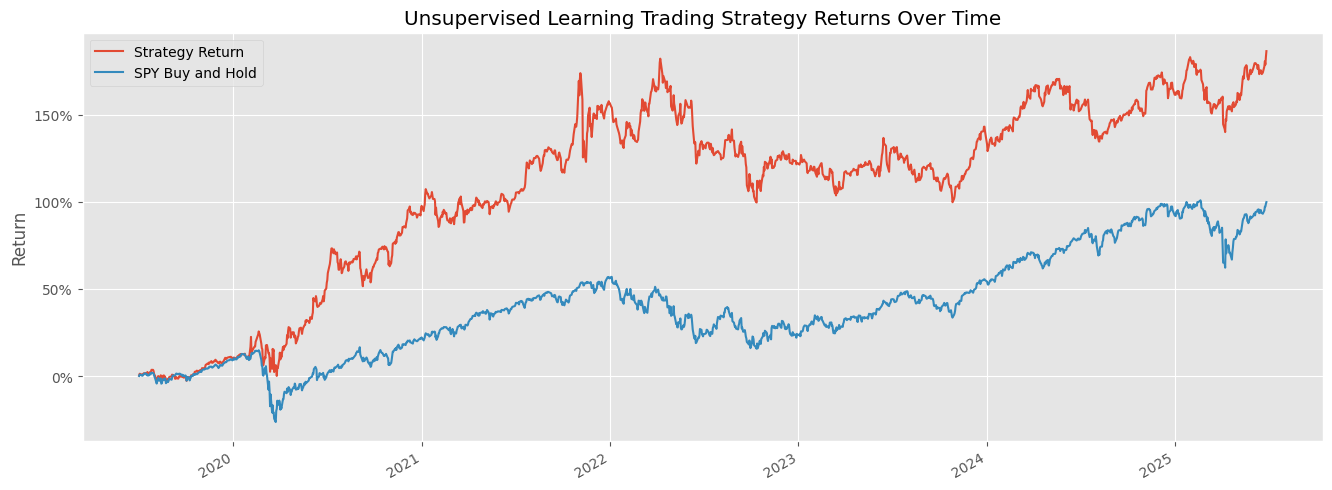

In [79]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp((np.log1p(portfolio_df)).cumsum())-1
portfolio_cumulative_return.plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()